In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Bayesian optimization 

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'0.3.1.dev0'

In this tutorial, we'll show a simple example of 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def objective(theta):
    return -0.4 * np.exp(-0.5*(theta - 2)**2) - 0.5 * np.exp(-0.1 * (theta + 1.3)**2) + 0.3

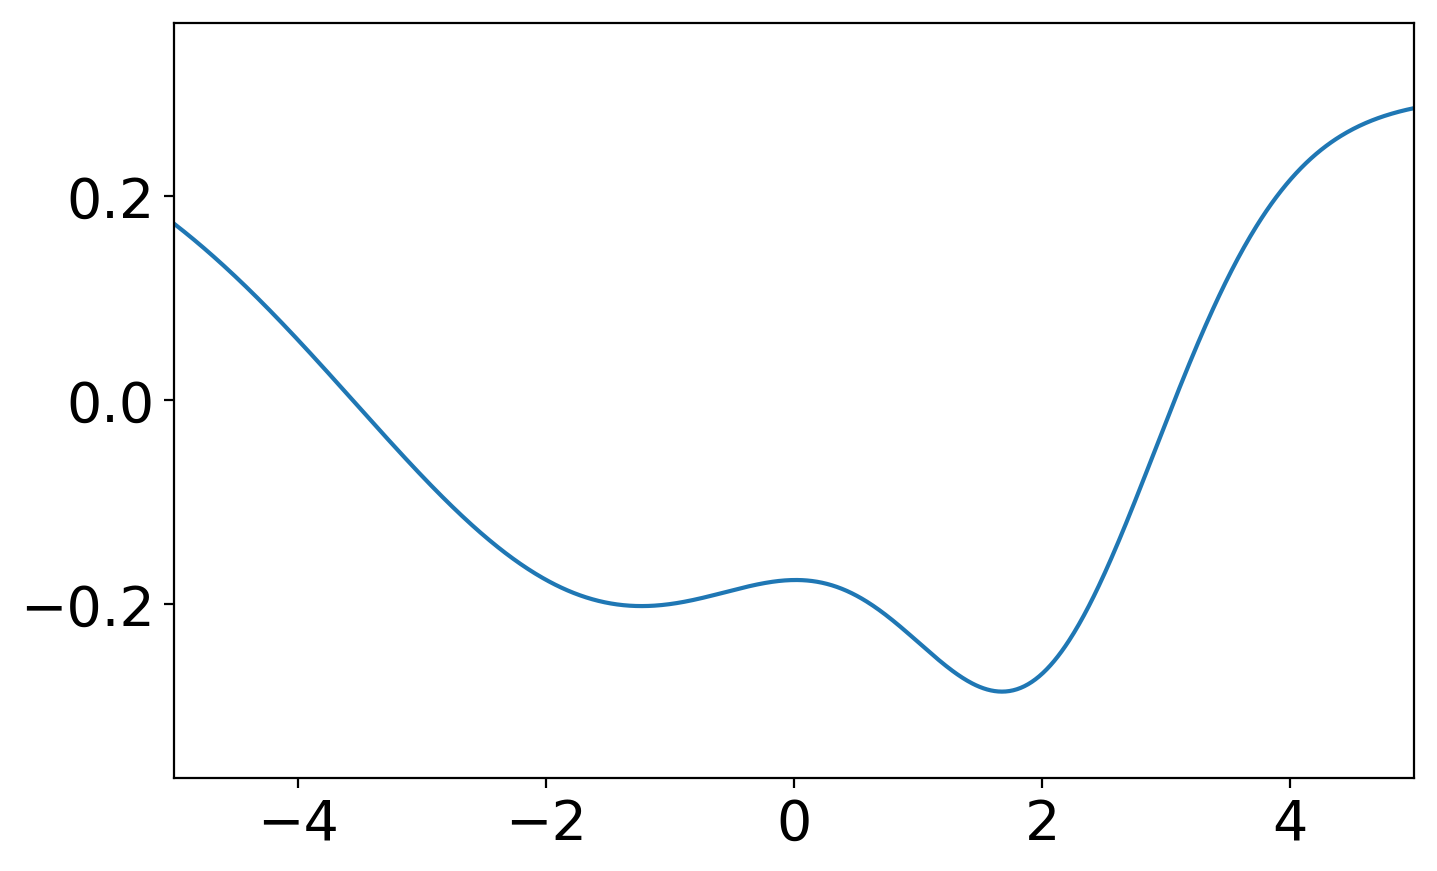

In [6]:
t = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 5))
plt.plot(t, objective(t))
plt.ylim(-0.37, 0.37)
plt.xlim(-5, 5);

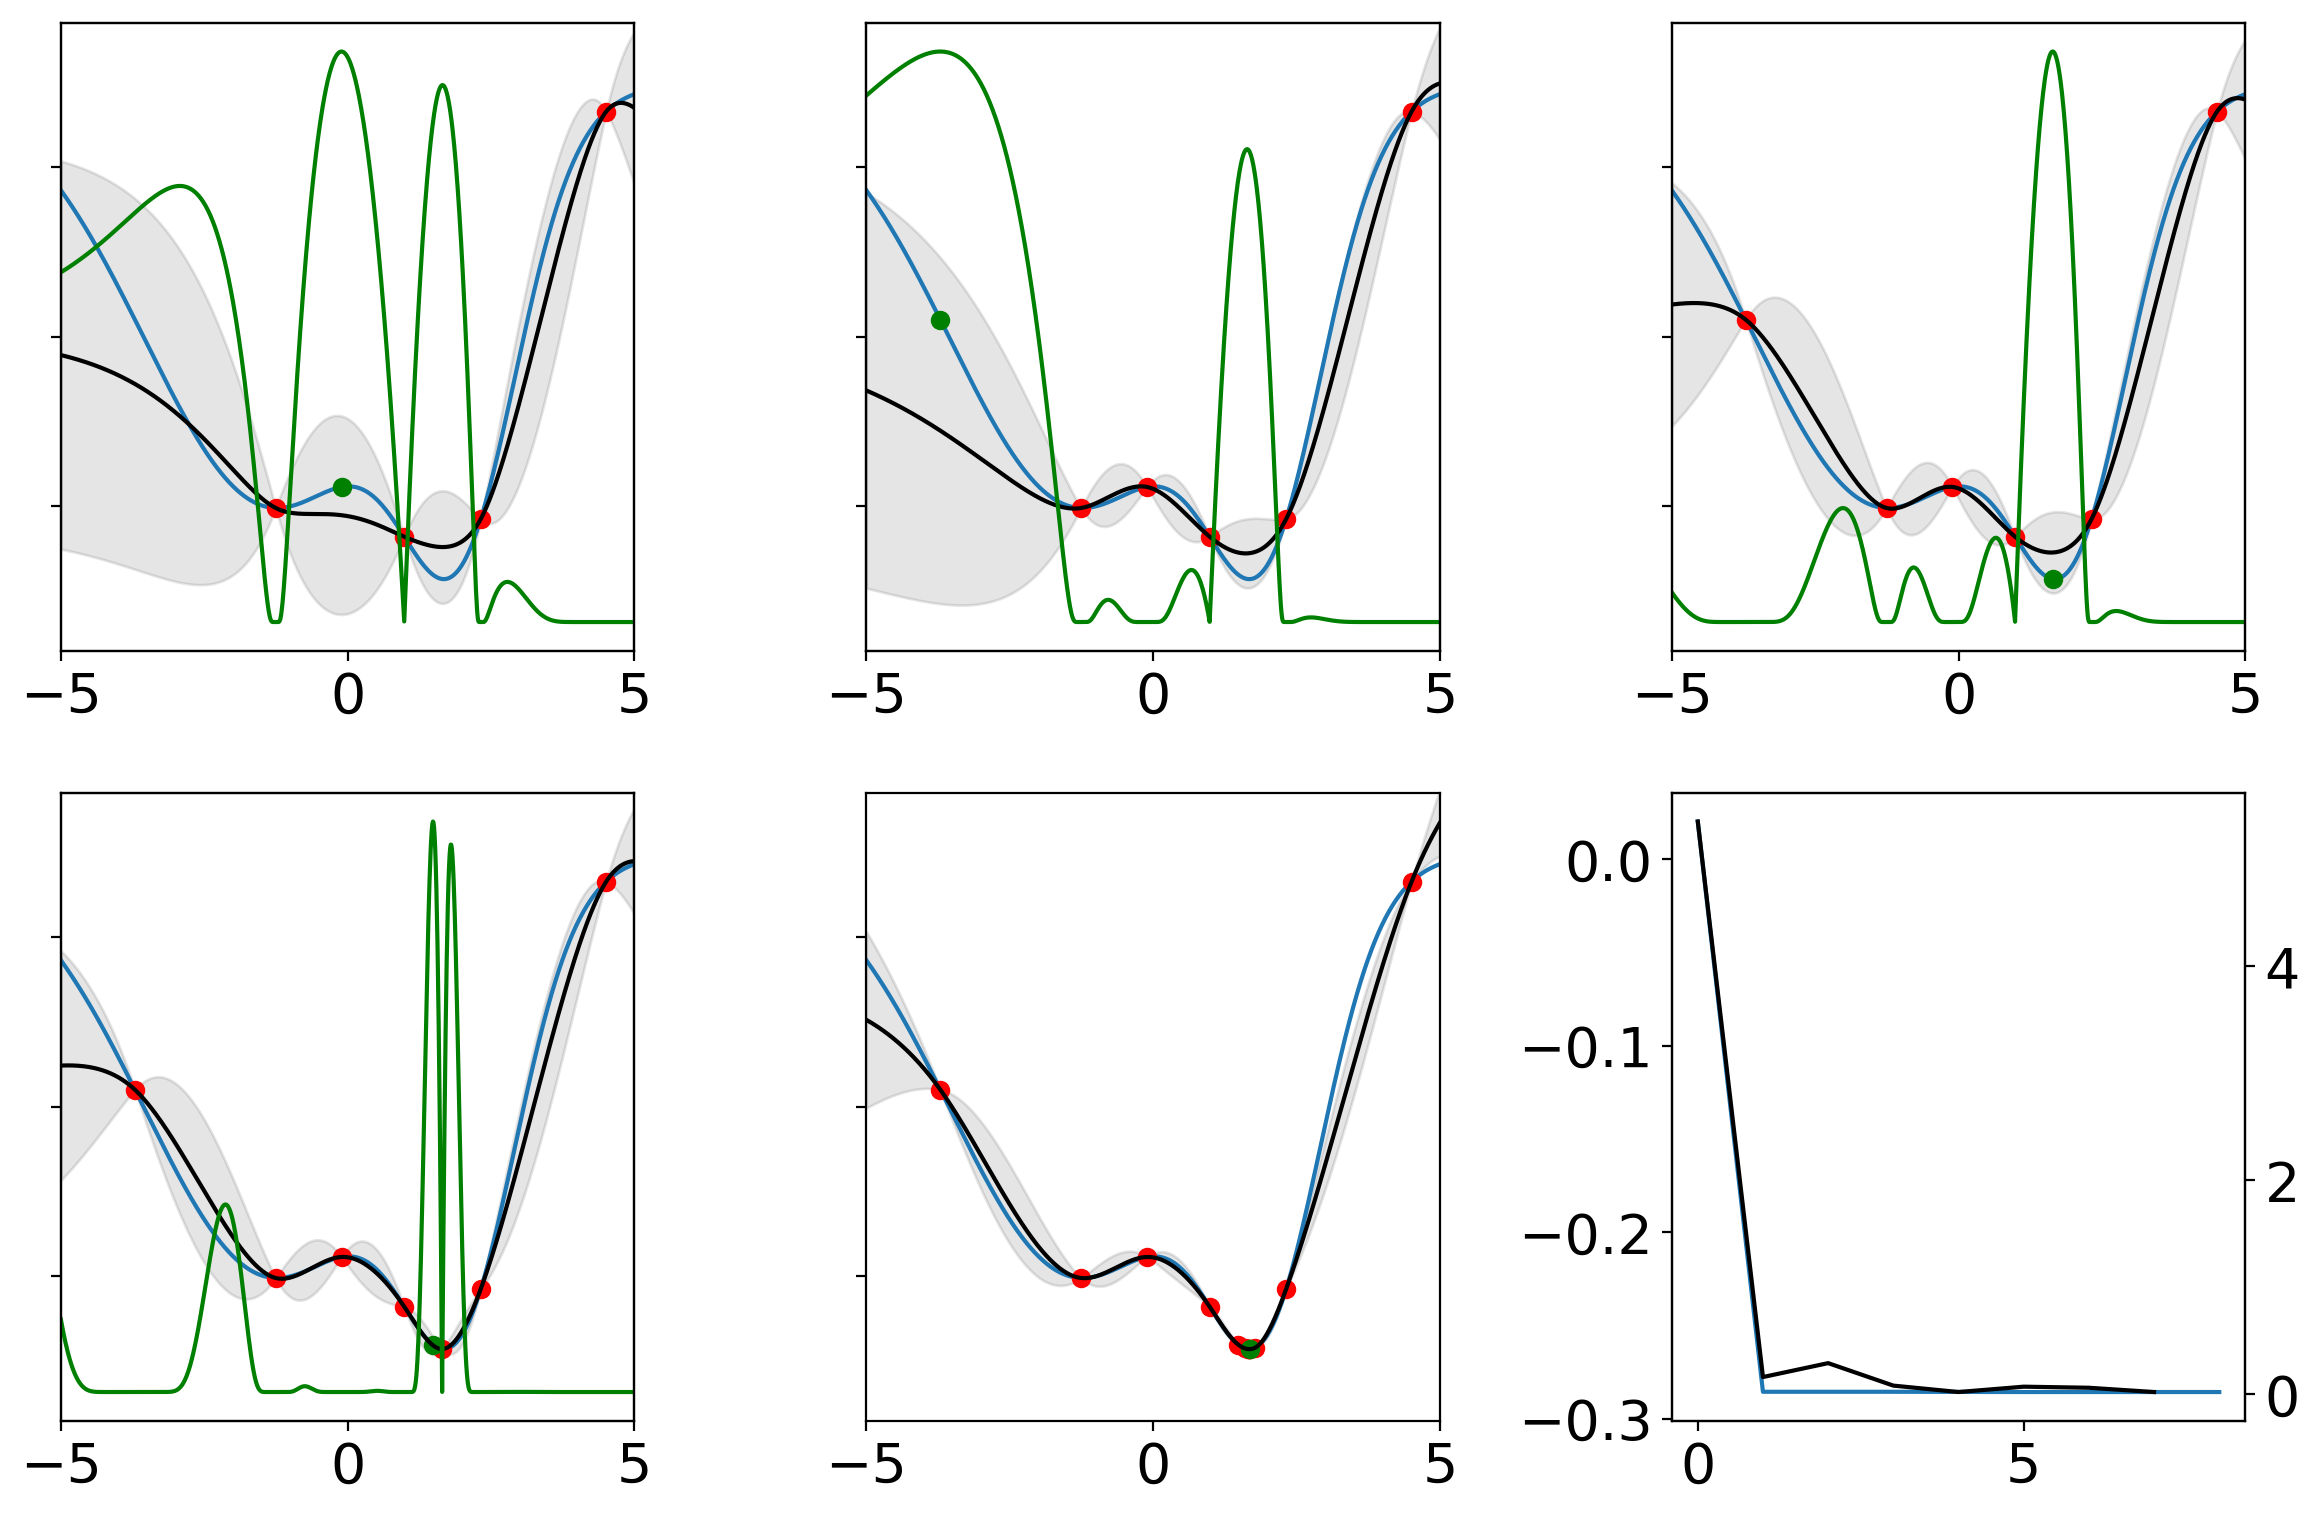

In [32]:
from george import kernels
from scipy.optimize import minimize
from scipy.special import erf

np.random.seed(42)
N_init = 4
train_theta = np.random.uniform(-5, 5, N_init)
train_f = objective(train_theta)

gp = george.GP(np.var(train_f) * kernels.Matern32Kernel(3.0),
               fit_mean=True)
gp.compute(train_theta)

def nll(params):
    gp.set_parameter_vector(params)
    g = gp.grad_log_likelihood(train_f, quiet=True)
    return -gp.log_likelihood(train_f, quiet=True), -g

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
j = 0

for i in range(10):
    # Update the GP parameters
    soln = minimize(nll, gp.get_parameter_vector(), jac=True)

    # Compute the acquisition function
    mu, var = gp.predict(train_f, t, return_var=True)
    std = np.sqrt(var)    
    f_min = np.min(train_f)
    chi = (f_min - mu) / std 
    Phi = 0.5 * (1.0 + erf(chi / np.sqrt(2)))
    phi = np.exp(-0.5 * chi**2) / np.sqrt(2*np.pi*var)
    A_ei = (f_min - mu) * Phi + var * phi

    # Add a new point
    train_theta = np.append(train_theta, t[np.argmax(A_ei)])
    train_f = np.append(train_f, objective(train_theta[-1]))
    gp.compute(train_theta)

    # Make the plots
    if i in [0, 1, 2, 3, 9]:
        ax = axes.flat[j]
        j += 1
        ax.plot(t, objective(t))
        ax.plot(train_theta[:-1], train_f[:-1], "or")
        ax.plot(train_theta[-1], train_f[-1], "og")
        ax.plot(t, mu, "k")
        ax.fill_between(t, mu+std, mu-std, color="k", alpha=0.1)
        if i <= 3:
            ax2 = ax.twinx()
            ax2.plot(t, A_ei, "g")
            ax2.set_yticks([])
        ax.set_ylim(-0.37, 0.37)
        ax.set_xlim(-5, 5)
        ax.set_yticklabels([])

ax = axes[-1, -1]
ax.plot(np.arange(len(train_theta)-N_init-1), np.minimum.accumulate(train_f[N_init+1:]))
ax2 = ax.twinx()
ax2.plot(np.arange(len(train_theta)-2-N_init), np.abs(np.diff(train_theta[N_init+1:])), "k")

plt.tight_layout()